# Churn prediction

The objective of this exercise is to build a model which can predict in advance, the merchants who are currently **active**  but are likely to **stop transacting** in the **near future**.The data we have available is that of around 1.5 million transactions across 2 years for 14,351 customers to train this model.

## Identifying churn 

A merchant is said to have churned if he has stopped transacting over a given observation period. The length of this observation period is an assumption we have to make. There are two key consideration for chosing an appropriate lengh for the observation period -  

1. The observation period should be long enough so that inactivity in the observation period can be inferred as the merchant having stopped using the service. If we choose a short period, say 1 week, it is possible that the merchants we identifiy as having churned, might not have had any transactions in a given week, but may have transactions at a later point in time. This would make our churn identification inaccurate.

2. The length of the window should be short enough so that -

    - We are able to identify churned merchants from the given dataset, which only has 2 years worth of data. If we choose a long window, say 18 months, we will not have enough data to identify the churn indicator for a majority of the customers and might not have enough data to train a model.
    - The churn prediction from the model is actually actionable. This is much more of a subjective criterial determined by the actual use case of the model. We might care more about the customers not likely to transact withing the next 30 days, in which case, the model shouls be trained to predict ove a similar time frame.


In [1]:
import pandas as pd
import numpy as np
import os
import project_s.src.common_utils as utils
import project_s.src as src
import math
from plotnine import *
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
pd.DataFrame.removeUnivarOutliers = utils.remove_univariate_outliers

In [2]:
raw_data = (pd.read_csv(os.path.join(src.dir_path , "data/raw/takehome_ds_written.csv"),index_col=0,parse_dates = ["time"]).
            assign(date = lambda x : pd.to_datetime(x["time"].dt.strftime('%Y-%m-%d')),# add date
                  amount_in_usd = lambda x :x.amount_usd_in_cents/100)) # amount in usd

def add_next_transaction(df):
    """
    add next transaction time for the same merchant to the raw data
    """
    return (df
             .sort_values("time")
             .assign( next_transaction_date = lambda x : x.date.shift(-1),
                      days_to_next_transaction = lambda x : (x.next_transaction_date - x.date).dt.days )) # null if no transaction after


tranformed_df= raw_data.groupby("merchant",as_index=False).apply(add_next_transaction ) # add fields for next transaction date and days to next trnsaction

In [3]:
churn_window_candidates = list(np.linspace(0,360,int(360/30)+1))

churn_data = []

for this_window in churn_window_candidates:
    churn_df = (tranformed_df.
    loc[lambda x : x["time"] < (x["time"].max() -timedelta( days = max(churn_window_candidates)))].
    groupby("merchant").
    apply(lambda x: x["days_to_next_transaction"].fillna(np.inf).gt(this_window).any() ))
    
    
    
    churn_data.append({"churn_window_len" : this_window , "churn_percent" :churn_df.mean()  , "n_merchants" :churn_df.count() })

churn_df = pd.DataFrame(churn_data).assign( decrease_percent = lambda x : ((x.churn_percent.shift(1) - x.churn_percent))*100 )



## Chosing the right performance window 

In [4]:
churn_df

,churn_window_len,churn_percent,n_merchants,decrease_percent
0,0.0,1.000000,6433,NaN
1,30.0,0.811130,6433,18.886989
2,60.0,0.679776,6433,13.135396
3,90.0,0.602363,6433,7.741334
4,120.0,0.547179,6433,5.518421
5,150.0,0.505518,6433,4.166019
6,180.0,0.468677,6433,3.684129
7,210.0,0.436966,6433,3.171149
8,240.0,0.414581,6433,2.238458
9,270.0,0.398414,6433,1.616664


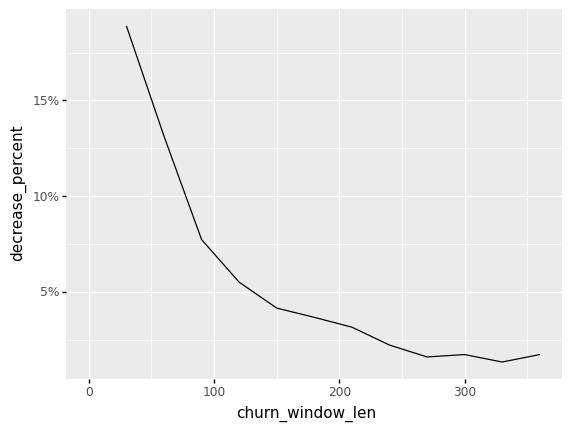

<ggplot: (-9223371958434406004)>

In [5]:
ggplot(churn_df, aes(x = "churn_window_len" , y = "decrease_percent")) + geom_line()  + scale_y_continuous(labels=lambda l: ["%d%%" % (v) for v in l])

Above we can see churn rates of the same cohort of active merchants(all active merchants in 2033) when we vary the size of the observation period.
As we increase the churn window from 0 to 360, the churn rate starts to stablize around 240 days, where most merchants who have churned in a 360 day observation period have already churned within a 240 day window and the incremental benefit of increasing the observation period is marginal. This indicates that a 240 day window for identification of churn will work reasonably well for training our model.

## Merchants already churned 

Now that we have fixed our definition of churn to be the absence of any transaction for 240 days, we can identfiy merchatns that have already churned at least once in the dataset.


In [6]:
churned_merchants = list((tranformed_df
     .loc[lambda x : x["date"] < (x["date"].max() -timedelta( days = 240))] # filter all activity for the last 240 days
     .assign(days_to_next_transaction = lambda x : x.days_to_next_transaction.fillna(np.inf))
     .loc[lambda x : x.days_to_next_transaction.gt(240)])["merchant"].unique())
pd.DataFrame(churned_merchants).to_csv(os.path.join(src.dir_path , "data/processed/churned_merchants.csv"))

4017 out of the 14351 merchants have churned at one point during thse 2 years.

## Sampling 

To generate the training data, I have chosen to sample merchant activity every 30 days. At each sampling date, if the merchant has not churned as of that date, I compute features over the past 240 days, the training period, to capture the merchant activity.The target variable would indicate wheather of not the customer had any transactions over the performance window, which we have chosen to be from the sampling date to 240 days after the sampling date.
I did not choose a higher sampling frequnecy because oversampling can result in a huge number of samples that can take a lot of time to compute and would not have a lot of additional information given that the merchants seem to be operating at about a 1 transaction per week median frequency.
Additionally, the choice to keep the training period also 240 days is arbitrary. Ideally this would be a parameter we would tune depending on model performance and data availability.

In [7]:
training_period = 240
performance_window = 240
date_samples = pd.date_range(raw_data["date"].min() + timedelta(days =training_period ) , raw_data["date"].max() - timedelta(days =performance_window ) , freq = '30D')

## Features

To capture merchant activity over the training window, I compute the following features. Each of them capture one of 3 attributes - 

1. Average activity during the training window
2. Recent activity 
3. Recent activity normalised by average activity in the performance window

In [1]:
feature_dict =  { "total_amount_usd" : "Total amount transacted over the training window" , 
            "count_txns" :  "Number of transactions over the training window" ,
            "avg_txn_amount" : "Average transaction amount over the training window",
            "count_txns_l30d" : "Number of transactions in the last 30 days",
            "count_txns_l60d" :"Number of transactions in the last 60 days" ,
            "count_txns_l90d" : "Number of transactions in the last 90 days",
            "count_txns_l30d_ratio" : "Number of transactions in the last 30 days divided by total transactions over the training window" , 
            "count_txns_l60d_ratio" :"Number of transactions in the last 60 days divided by total transactions over the training window",
            "count_txns_l90d_ratio" :"Number of transactions in the last 90 days divided by total transactions over the training window"}

feature_dict

{'total_amount_usd': 'Total amount transacted over the training window',
 'count_txns': 'Number of transactions over the training window',
 'avg_txn_amount': 'Average transaction amount over the training window',
 'count_txns_l30d': 'Number of transactions in the last 30 days',
 'count_txns_l60d': 'Number of transactions in the last 60 days',
 'count_txns_l90d': 'Number of transactions in the last 90 days',
 'count_txns_l30d_ratio': 'Number of transactions in the last 30 days divided by total transactions over the training window',
 'count_txns_l60d_ratio': 'Number of transactions in the last 60 days divided by total transactions over the training window',
 'count_txns_l90d_ratio': 'Number of transactions in the last 90 days divided by total transactions over the training window'}

In [9]:
def create_features_target(grouped_df):
    training_window = grouped_df[grouped_df.offset_date <=0]
    
    if training_window.shape[0]==0: # no activity in traning window, customer already churned
        return None
    performance_window = grouped_df[grouped_df.offset_date >0]
    features = {}
    features = { "total_amount_usd" : training_window["amount_in_usd"].sum(), # total amount of transactions
                 "count_txns" : training_window["amount_in_usd"].count() , # total number of transactions
                 "avg_txn_amount" : training_window["amount_in_usd"].mean(), # average transaction size
                 "count_txns_l30d" : training_window.loc[(training_window["offset_date"]>=-30) ,"amount_in_usd"].count(),
                 "count_txns_l60d" : training_window.loc[(training_window["offset_date"]>=-60) ,"amount_in_usd"].count(),
                 "count_txns_l90d" : training_window.loc[(training_window["offset_date"]>=-90) ,"amount_in_usd"].count(),
                 "count_txns_l30d_ratio" : training_window.loc[(training_window["offset_date"]>=-30) ,"amount_in_usd"].count()/training_window["amount_in_usd"].count(),
                 "count_txns_l60d_ratio" : training_window.loc[(training_window["offset_date"]>=-60) ,"amount_in_usd"].count()/training_window["amount_in_usd"].count(),
                 "count_txns_l90d_ratio" : training_window.loc[(training_window["offset_date"]>=-90) ,"amount_in_usd"].count()/training_window["amount_in_usd"].count()}
    
    churn_indicator = 1 if performance_window.shape[0]==0 else 0 # churned if merchant did not transact within performance window
    features.update({"churn_indicator":churn_indicator})
    training_row = pd.DataFrame( features, index= [0] )
    return training_row
    

In [10]:
training_df = pd.DataFrame()
for date_sample in date_samples:
    training_df = pd.concat([training_df ,
                            (tranformed_df.assign(sample_date =date_sample ,
                                                        offset_date = lambda x :(x.date - x.sample_date).dt.days)) ],axis = 0)
    
    

In [11]:
training_data = (training_df
    .loc[lambda x : (x.offset_date >-training_period) & (x.offset_date <=performance_window)]
    .groupby(["merchant","sample_date"])
    .apply(create_features_target)).reset_index().drop(["level_2"],axis = 1)


## Model Training

In [12]:
import py_mob
features = [ "total_amount_usd" , 
            "count_txns" ,
            "avg_txn_amount",
            "count_txns_l30d",
            "count_txns_l60d",
            "count_txns_l90d",
            "count_txns_l30d_ratio", 
            "count_txns_l60d_ratio" ,
            "count_txns_l90d_ratio" ]

target = "churn_indicator"
feature_summary = []
for feat in features : 
    feat_binned = py_mob.qtl_bin(training_data[feat], training_data[target] )
    summ_bin = py_mob.summ_bin(feat_binned )
    summ_bin.update({"feature" : feat})
    feature_summary.append(summ_bin)
    
pd.DataFrame(feature_summary)

,sample size,bad rate,iv,ks,missing,feature
0,51764,0.3032,0.2557,21.13,0.0,total_amount_usd
1,51764,0.3032,0.2735,21.04,0.0,count_txns
2,51764,0.3032,0.0054,3.25,0.0,avg_txn_amount
3,51764,0.3032,1.3531,51.26,0.0,count_txns_l30d
4,51764,0.3032,1.2477,48.32,0.0,count_txns_l60d
5,51764,0.3032,1.0598,42.23,0.0,count_txns_l90d
6,51764,0.3032,1.0685,48.07,0.0,count_txns_l30d_ratio
7,51764,0.3032,0.4920,33.98,0.0,count_txns_l60d_ratio
8,51764,0.3032,0.2410,24.16,0.0,count_txns_l90d_ratio


In [22]:
feat = "count_txns_l30d_ratio"
feat_binned = py_mob.qtl_bin(training_data[feat], training_data[target] )

In [23]:
pd.DataFrame(feat_binned['tbl']).to_clipboard()

In [25]:
training_data[feat].describe(np.linspace(0,1,11))

count    51764.000000
mean         0.235151
std          0.332740
min          0.000000
0%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.064516
60%          0.159091
70%          0.250523
80%          0.489177
90%          1.000000
100%         1.000000
max          1.000000
Name: count_txns_l30d_ratio, dtype: float64

Above is information value for all our features over the training set, which indicates the strength of a feature's relationship with churn.
The churn rate for the sampled training set is around 30% on a traning set size of 51,764 after sampling.
Looking at the information value, almost all features except for average transaction amount seem to be well correlated with churn. Clealy, transaction activity has a lot correlation future churn. Also ,the more recent transaction activity is more powerfully correlated with future churn. 
We go ahead with training an xgboost model on this traning set with these features. 

In [26]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'max_depth': [3, 4, 5],
        'learning_rate' : [0.001, 0.01,0.1],
        'n_estimators' : [50,100,150,200]
        }

xgb = XGBClassifier(objective='binary:logistic',silent=True, nthread=18)

folds = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

X_train, X_test, y_train, y_test = train_test_split(training_data[features], training_data[target], test_size=0.33, random_state=42)

grid_search = GridSearchCV(xgb, param_grid=params, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3 )

# Here we go
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001242D6C5648>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=n...
                                     n_estimators=100, n_jobs=None, nthread=18,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, silent=True,
                

In [59]:
def ks(data=None, target=None, prob=None, asc=False):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10, duplicates='raise')
    grouped = data.groupby('bucket', as_index=False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events'] = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable['total'] = grouped.count()['target0']
    kstable['bucket_event_rate'] =kstable.events/kstable.total
    kstable = kstable.sort_values(by="min_prob", ascending=asc).reset_index(drop=True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate'] = (kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3) * 100

    # Formating
    kstable['cum_eventrate'] = kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate'] = kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    # kstable.index = range(1, len(kstable)+1)
    kstable.index = range(1, 11)
    kstable.index.rename('Decile', inplace=True)
    return kstable

### Model evaluation

In [76]:
from sklearn.metrics import roc_auc_score

classifier = grid_search.best_estimator_
classifier.fit(X_train,y_train)
y_train_probs = classifier.predict_proba(X_train)[:, 1]
y_test_probs = classifier.predict_proba(X_test)[:, 1]
train_auc = roc_auc_score(y_train, y_train_probs)
test_auc = roc_auc_score(y_test, y_test_probs)
print(f"Model results. Train AUC : {train_auc}. Test AUC : {test_auc}")

Model results. Train AUC : 0.8787946226704462. Test AUC : 0.851806268393682


#### KS table

In [61]:
test_result_df = pd.DataFrame({"target" : y_test , "proba": y_test_probs })
ks(test_result_df,"target","proba")

,min_prob,max_prob,events,nonevents,total,eventrate,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,,,
1,0.680263,0.933116,1380,315,1695,0.814159,26.10%,2.67%,26.10%,2.67%,23.4
2,0.606068,0.679982,1132,588,1720,0.658140,21.41%,4.99%,47.50%,7.66%,39.8
3,0.492019,0.605952,909,801,1710,0.531579,17.19%,6.79%,64.69%,14.45%,50.2
4,0.325948,0.491943,660,1043,1703,0.387551,12.48%,8.84%,77.17%,23.29%,53.9
5,0.225464,0.325637,522,1191,1713,0.304729,9.87%,10.10%,87.05%,33.39%,53.7
6,0.158576,0.225438,316,1393,1709,0.184903,5.98%,11.81%,93.02%,45.20%,47.8
7,0.096585,0.158527,181,1527,1708,0.105972,3.42%,12.95%,96.44%,58.14%,38.3
8,0.050022,0.096504,111,1597,1708,0.064988,2.10%,13.54%,98.54%,71.68%,26.9
9,0.017068,0.050011,62,1646,1708,0.036300,1.17%,13.96%,99.72%,85.64%,14.1


The final classifier trained is a pretty good one. The test AUC is almost 0.85. However, from a usage perspective, we need to choose a threshold for the predicted probability of churn above which we will take necessary actions to avoid churn. This obviously comes down to the trade off between the cost of said action and our need to cut down on churn. 
The above table will help us navigate this tradeoff. For example, if we keep the probability threshold at around 0.5(row 3), we will have to action on 30% of the population on average. However, this 30% population would account for 65% of all churners on average. 

### Feature importances

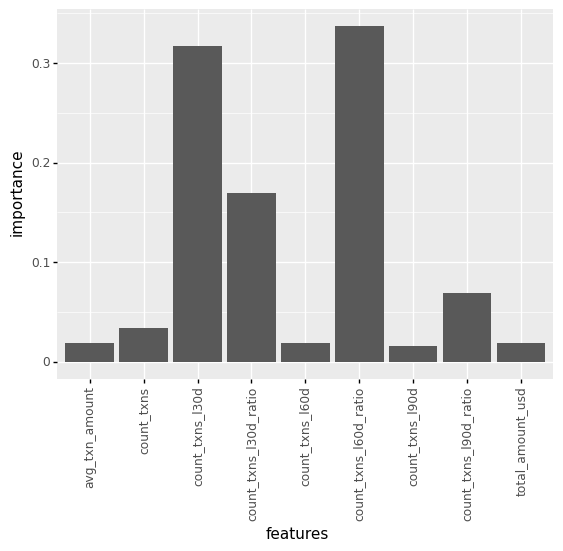

<ggplot: (-9223371944075838280)>

In [68]:
feature_importance_df = pd.DataFrame({"features":features , "importance": classifier.feature_importances_})
ggplot(feature_importance_df , aes(x = "features" , y = "importance")) + geom_col() +theme(axis_text_x= element_text(angle = 90))


Within the model , the most important 2 features are those relating to recent activity and recent activity nomalised by overall level of activity which makes a lot of sense. 

In [109]:
# predicting which merchants, currently active are likely to churn in the future. 
as_of_date = tranformed_df["date"].max()
X_oot = (tranformed_df
     .assign(offset_date = lambda x : (x.date - as_of_date).dt.days)
     .loc[lambda x : x.offset_date > -performance_window]
     .groupby("merchant")
     .apply(create_features_target)
     ).reset_index().drop(["level_1","churn_indicator"],axis = 1)
predicted_churn_prob_df = pd.DataFrame({"merchant" : X_oot["merchant"] , "predicted_churn_prob":classifier.predict_proba(X_oot[features])[:, 1]})
predicted_churn_prob_df.to_csv(os.path.join(src.dir_path , "data/processed/active_merchant_churn_probs.csv"))

## Scope for improvement - 
1. Explore more hyperparamenter combinations and try to run other models possible 
2. Feature engineering by creating new features as well as tweaking the windows for time window features. Tweaking the training window to make it shorter. Clearly most of the value lies in recent activity so we might be able to make the training window shorter

## Steps Further - 
1. We need to choose an appropriate threshold for the probability outpit from the model, above which we will comission an action to curtail possible churn.
2. We need to find similar data to be able to validate this model.